In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

2024-03-26 11:41:18.498685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 11:41:19.012969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 11:41:19.023604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 11:41:21.952971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

In [5]:
df = pd.read_csv('time series data.csv')

df.head()

,t,ProductP1,ProductP2,ProductP3,ProductP4,ProductP5,price,temperature
0,1,197,66,266,113,2,1,18
1,2,153,44,264,74,1,2,21
2,3,128,55,317,116,0,1,19
3,4,133,57,390,70,0,2,17
4,5,120,47,440,141,1,1,18


In [4]:
msk = (df.index < len(df) - int(0.2 * len(df)))
df_train = df[msk].copy()
df_test = df[~msk].copy()

<Axes: >

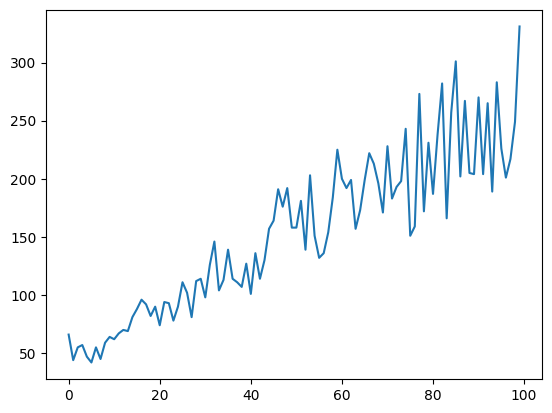

In [5]:
df['ProductP2'].plot()

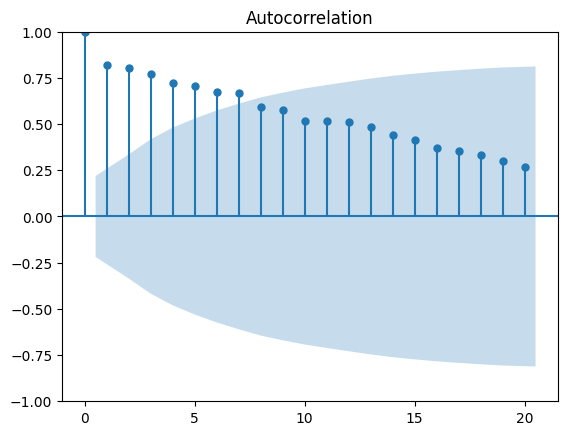

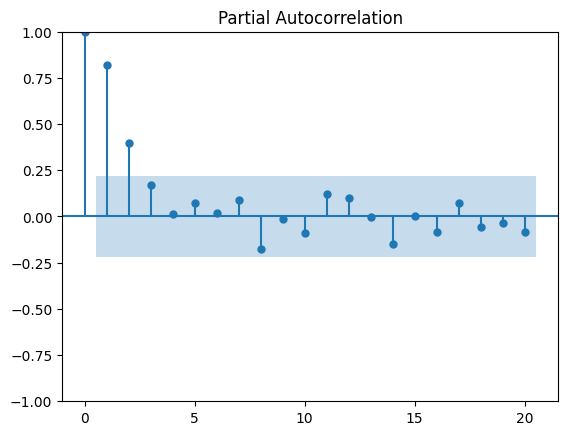

In [6]:
acf_original = plot_acf(df_train['ProductP2'])
plt.show()

pacf_original = plot_pacf(df_train['ProductP2'])
plt.show()

In [7]:
adf_test = adfuller(df_train['ProductP2'])
print(f'p-value: {adf_test[1]}')

p-value: 0.829617589607836


In [8]:
diff_data = df_train['ProductP2'].diff()
diff_data = diff_data.dropna()
diff_data.isna().sum()

0

In [9]:
adf_test = adfuller(diff_data)
print(f'p-value: {adf_test[1]}')

p-value: 1.1663151900765919e-05


<Axes: >

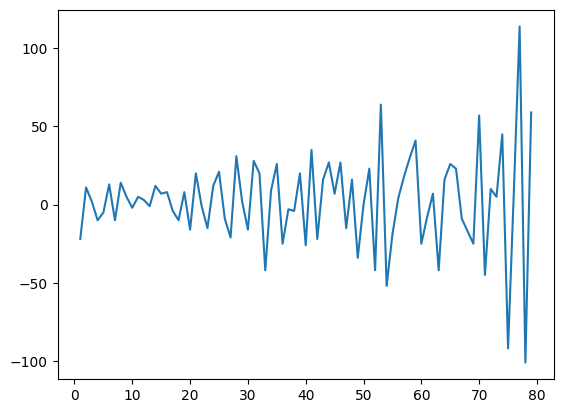

In [10]:
diff_data.plot()

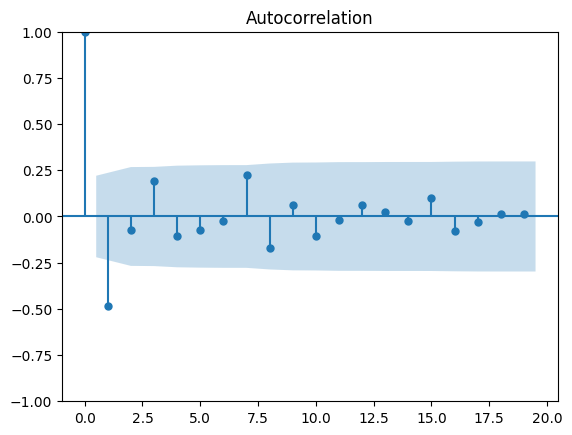

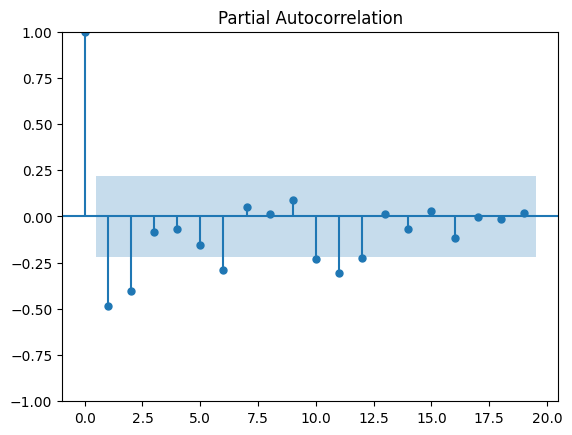

In [11]:
acf_original = plot_acf(diff_data)
plt.show()

pacf_original = plot_pacf(diff_data)
plt.show()

In [12]:
auto = auto_arima(df_train['ProductP2'], seasonal = False, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(2,1,0)(0,0,0)[0] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -364.911
Date:                Tue, 26 Mar 2024   AIC                            737.822
Time:                        10:43:17   BIC                            747.300
Sample:                             0   HQIC                           741.619
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4737      2.860      1.564      0.118      -1.131      10.078
ar.L1         -0.6902      0.080     -8.582      0.000      -0.848      -0.533
ar.L2         -0.4

In [13]:
auto = auto_arima(df_train['ProductP2'], seasonal = True, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(2,1,0)(0,0,0)[1] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -364.911
Date:                Tue, 26 Mar 2024   AIC                            737.822
Time:                        10:43:41   BIC                            747.300
Sample:                             0   HQIC                           741.619
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4737      2.860      1.564      0.118      -1.131      10.078
ar.L1         -0.6902      0.080     -8.582      0.000      -0.848      -0.533
ar.L2         -0.4

In [19]:
model = ARIMA(df_train['ProductP2'], order = (2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              ProductP2   No. Observations:                   80
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -366.161
Date:                Tue, 26 Mar 2024   AIC                            738.322
Time:                        10:45:24   BIC                            745.431
Sample:                             0   HQIC                           741.170
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6716      0.085     -7.917      0.000      -0.838      -0.505
ar.L2         -0.4044      0.073     -5.558      0.000      -0.547      -0.262
sigma2       616.6120     85.140      7.242      0.0

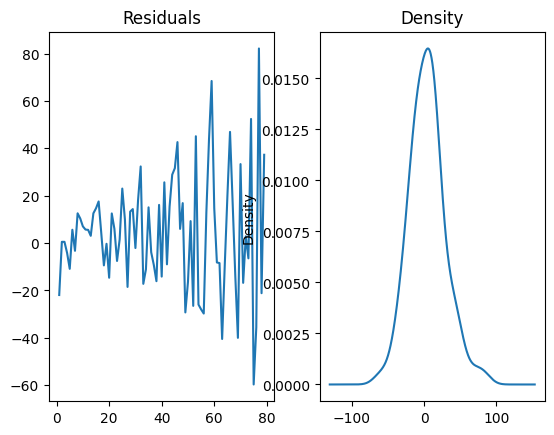

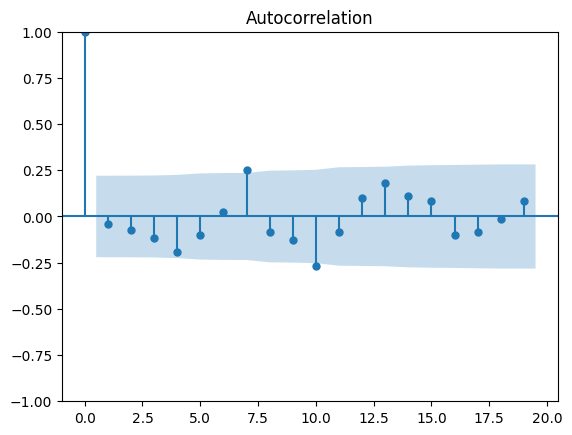

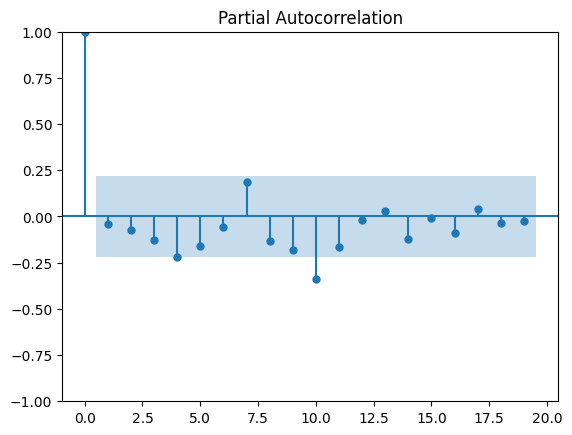

In [20]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

acf_original = plot_acf(residuals)
plt.show()

pacf_original = plot_pacf(residuals)
plt.show()

MAPE : 15.868139977738775


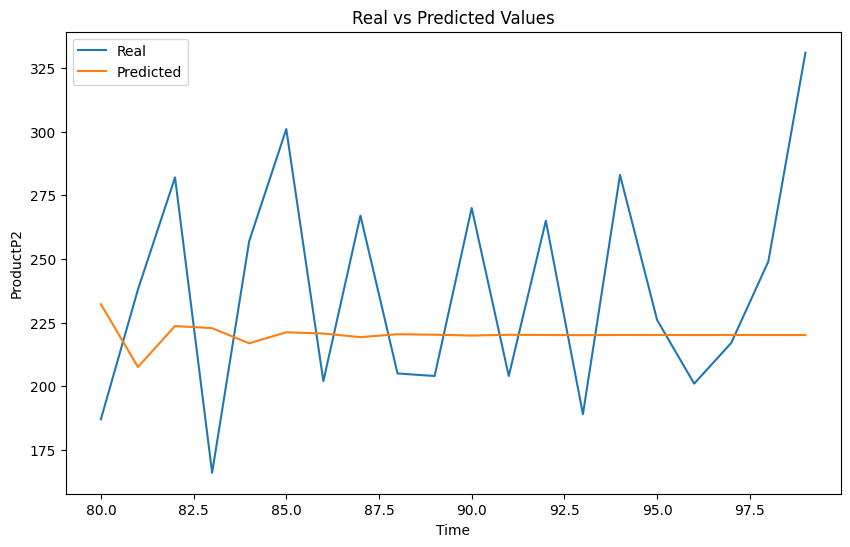

In [21]:
forecast = model_fit.forecast(steps = len(df_test['ProductP2']))
mape_value = mape(df_test['ProductP2'], forecast)
predicted_values = forecast

print(f"MAPE : {mape_value}")  

plt.figure(figsize = (10, 6))
plt.plot(df_test.index, df_test['ProductP2'], label='Real')
plt.plot(df_test.index, predicted_values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('ProductP2')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()

Epoch 1/1000
73/73 [==============================] - 9s 24ms/step - loss: 12458.0859 - mae: 94.2192 - val_loss: 3408.6179 - val_mae: 47.2670
Epoch 2/1000
73/73 [==============================] - 1s 11ms/step - loss: 789.1218 - mae: 21.1919 - val_loss: 3260.3887 - val_mae: 49.0978
Epoch 3/1000
73/73 [==============================] - 1s 12ms/step - loss: 789.4872 - mae: 21.1739 - val_loss: 4076.3059 - val_mae: 53.5840
Epoch 4/1000
73/73 [==============================] - 1s 14ms/step - loss: 845.0089 - mae: 21.4386 - val_loss: 2822.8789 - val_mae: 45.3136
Epoch 5/1000
73/73 [==============================] - 1s 11ms/step - loss: 785.1621 - mae: 20.9166 - val_loss: 1571.9977 - val_mae: 34.4673
Epoch 6/1000
73/73 [==============================] - 1s 11ms/step - loss: 698.5713 - mae: 19.8572 - val_loss: 1754.1766 - val_mae: 34.8235
Epoch 7/1000
73/73 [==============================] - 1s 11ms/step - loss: 671.0386 - mae: 20.2222 - val_loss: 1552.2524 - val_mae: 33.9542
Epoch 8/1000
73/73

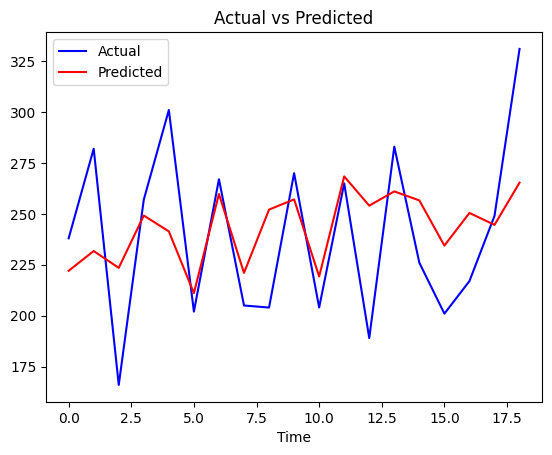

16.59182572166027


In [34]:
data = df['ProductP2']
data = data.values.reshape(-1, 1)

time_steps = 8
n_neurons = 16

# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'relu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
# model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
# model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
model.add(LSTM(units = n_neurons, return_sequences = False, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 11, restore_best_weights = True)

model.fit(X_train, y_train, epochs = 1000, batch_size = 1, validation_data = [X_test, y_test], callbacks = [early_stopping])

predicted_values = model.predict(X_test)

plt.plot(y_test, label = 'Actual', color = 'blue')
plt.plot(predicted_values, label = 'Predicted', color = 'red')
plt.xlabel('Time')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

print(np.mean(np.abs((y_test - predicted_values) / y_test)) * 100)

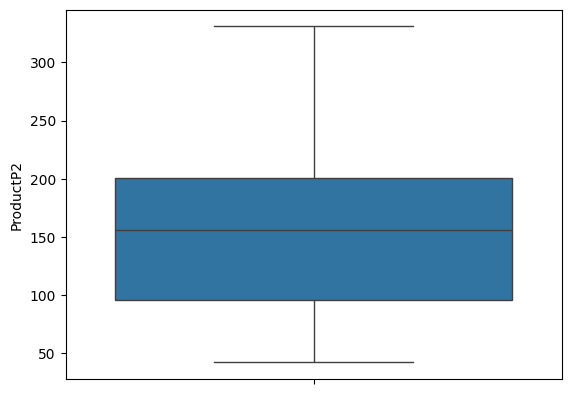

In [37]:
sns.boxplot(df['ProductP2'])
plt.show()

In [18]:
class Model():
    def __init__(self, n_layers = 2, n_neurons = 16, if_scale = False, time_steps = 8):
        self.data = df['ProductP2']
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.if_scale = if_scale
        self.time_steps = time_steps

    
    def get_params(self, deep = True):
        return {
            'n_layers': self.n_layers,
            'n_neurons': self.n_neurons,
            'if_scale': self.if_scale,
            'time_steps': self.time_steps
        }
    
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    
    def create_model(self): 
        data = self.data.values.reshape(-1, 1)

        if self.if_scale == 1:
            scaler = MinMaxScaler()
            data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(len(data) - self.time_steps):
            X.append(data[i : (i + self.time_steps), 0])
            y.append(data[i + self.time_steps, 0])

        X, y = np.array(X), np.array(y)

        split = int(0.8 * len(X))
        self.X_train, self.X_test = X[:split], X[split:]
        self.y_train, self.y_test = y[:split], y[split:]

        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        self.model = Sequential()
        if self.n_layers == 1:
            self.model.add(LSTM(units = self.n_neurons, return_sequences = False, input_shape = (self.time_steps, 1), activation = 'relu'))
        else:
            self.model.add(LSTM(units = self.n_neurons, return_sequences = True, input_shape = (self.time_steps, 1), activation = 'relu'))
            for i in range(self.n_layers - 2):
                self.model.add(LSTM(units = self.n_neurons, return_sequences = True, activation = 'relu'))

            self.model.add(LSTM(units = self.n_neurons, return_sequences = False, activation = 'relu'))


        self.model.add(Dense(units = 1, activation = 'linear'))
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

    
    def fit(self, X, y):
        self.create_model()
        print(f"n_layers = {self.n_layers}, n_neurons = {self.n_neurons}, if_scale = {self.if_scale}, time_steps = {self.time_steps}.")
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 11, restore_best_weights = True)
        self.model.fit(self.X_train, 
                  self.y_train, 
                  epochs = 1000, 
                  batch_size = 1, 
                  validation_data = [self.X_train, self.y_train], 
                  callbacks = [early_stopping], 
                  verbose = False)

        predicted_values = self.model.predict(self.X_train)
        return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


    def score(self, X, y):
        self.model.predict(self.X_test)
        predicted_values = self.model.predict(self.X_test)
        print(f"MAPE: {np.mean(np.abs((self.y_test - predicted_values) / self.y_test)) * 100}\n")
        return -np.mean(np.abs((self.y_test - predicted_values) / self.y_test)) * 100

In [19]:
param_dist = {
    'n_layers': np.arange(1, 7, 1),
    'n_neurons' : np.arange(4, 65, 1),
    'if_scale' : [0, 1],
    'time_steps' : np.arange(2, 17, 1)
}

random_search = RandomizedSearchCV(Model(), param_distributions = param_dist, n_iter = 25, cv = 2)

random_search.fit(np.zeros((10, 10)), np.zeros(10))

best_params = random_search.best_params_
print("Best Parameters:", best_params, '\n\n\n\n\n')

cv_results = random_search.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Iteration {i + 1} - Parameters: {cv_results['params'][i]}, Mean Test Score: {cv_results['mean_test_score'][i]}\n")

n_layers = 5, n_neurons = 24, if_scale = 0, time_steps = 9.
1/1 [==============================] - 0s 37ms/step
MAPE: 18.419768993695477

n_layers = 5, n_neurons = 24, if_scale = 0, time_steps = 9.
1/1 [==============================] - 0s 64ms/step
MAPE: 16.211550929057204

n_layers = 3, n_neurons = 5, if_scale = 1, time_steps = 11.
1/1 [==============================] - 0s 30ms/step
MAPE: 20.203759567424644

n_layers = 3, n_neurons = 5, if_scale = 1, time_steps = 11.
1/1 [==============================] - 0s 27ms/step
MAPE: 22.5390949937518

n_layers = 5, n_neurons = 33, if_scale = 0, time_steps = 4.
1/1 [==============================] - 0s 31ms/step
MAPE: 15.861270093436076

n_layers = 5, n_neurons = 33, if_scale = 0, time_steps = 4.
1/1 [==============================] - 0s 30ms/step
MAPE: 15.895924971746073

n_layers = 5, n_neurons = 21, if_scale = 1, time_steps = 11.
1/1 [==============================] - 0s 30ms/step
MAPE: 19.154442187604193

n_layers = 5, n_neurons = 21, if_sc

/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 1, n_neurons = 59, if_scale = 1, time_steps = 4.
1/1 [==============================] - 0s 24ms/step
MAPE: 18.662706037660797



/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 3, n_neurons = 52, if_scale = 1, time_steps = 4.
1/1 [==============================] - 0s 22ms/step
MAPE: 18.83883627361624



/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 3, n_neurons = 52, if_scale = 1, time_steps = 4.
1/1 [==============================] - 0s 36ms/step


/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


1/1 [==============================] - 0s 38ms/step
MAPE: 19.68772236700898

n_layers = 2, n_neurons = 39, if_scale = 0, time_steps = 4.
1/1 [==============================] - 0s 31ms/step
MAPE: 16.32354183750465

n_layers = 2, n_neurons = 39, if_scale = 0, time_steps = 4.
1/1 [==============================] - 0s 46ms/step
MAPE: 16.005403375191875

n_layers = 5, n_neurons = 28, if_scale = 1, time_steps = 13.
1/1 [==============================] - 0s 41ms/step
MAPE: 18.853053239034026

n_layers = 5, n_neurons = 28, if_scale = 1, time_steps = 13.
1/1 [==============================] - 0s 47ms/step
MAPE: 19.109932451172487

n_layers = 4, n_neurons = 9, if_scale = 1, time_steps = 7.
1/1 [==============================] - 0s 36ms/step
MAPE: 20.89903212878646

n_layers = 4, n_neurons = 9, if_scale = 1, time_steps = 7.
1/1 [==============================] - 0s 34ms/step
MAPE: 19.376069348690482

n_layers = 4, n_neurons = 51, if_scale = 0, time_steps = 11.
1/1 [==============================]

/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


1/1 [==============================] - 0s 41ms/step
MAPE: 19.163305371154387

n_layers = 6, n_neurons = 50, if_scale = 1, time_steps = 4.
1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_104653/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


1/1 [==============================] - 0s 43ms/step
MAPE: 19.541741216284887

n_layers = 6, n_neurons = 60, if_scale = 0, time_steps = 4.
3/3 [==============================] - 1s 8ms/step
Best Parameters: {'time_steps': 4, 'n_neurons': 60, 'n_layers': 6, 'if_scale': 0} 





Iteration 1 - Parameters: {'time_steps': 9, 'n_neurons': 24, 'n_layers': 5, 'if_scale': 0}, Mean Test Score: -17.31565996137634

Iteration 2 - Parameters: {'time_steps': 11, 'n_neurons': 5, 'n_layers': 3, 'if_scale': 1}, Mean Test Score: -21.37142728058822

Iteration 3 - Parameters: {'time_steps': 4, 'n_neurons': 33, 'n_layers': 5, 'if_scale': 0}, Mean Test Score: -15.878597532591074

Iteration 4 - Parameters: {'time_steps': 11, 'n_neurons': 21, 'n_layers': 5, 'if_scale': 1}, Mean Test Score: -19.194788092223522

Iteration 5 - Parameters: {'time_steps': 2, 'n_neurons': 35, 'n_layers': 1, 'if_scale': 0}, Mean Test Score: -16.286248524212816

Iteration 6 - Parameters: {'time_steps': 2, 'n_neurons': 63, 'n_layers': 4

In [23]:
model = Model(6, 60, 0, 4)
model.fit(np.zeros((10, 10)), np.zeros(10))

n_layers = 6, n_neurons = 60, if_scale = 0, time_steps = 4.
3/3 [==============================] - 2s 26ms/step


-53.15019561597393

1/1 [==============================] - 0s 62ms/step


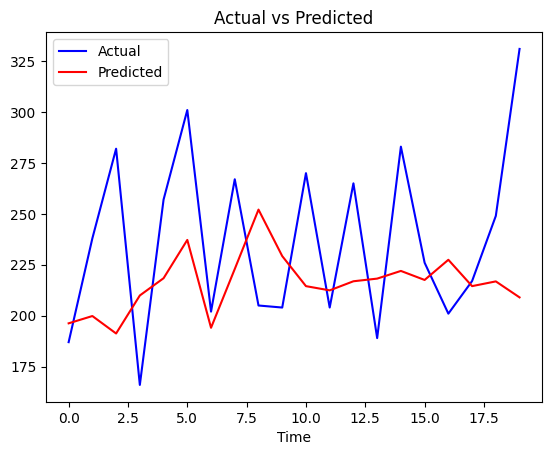

15.847452347820399


In [24]:
X_test = model.X_test
y_test = model.y_test
model = model.model

predicted_values = model.predict(X_test)

plt.plot(y_test, label = 'Actual', color = 'blue')
plt.plot(predicted_values, label = 'Predicted', color = 'red')
plt.xlabel('Time')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

print(np.mean(np.abs((y_test - predicted_values) / y_test)) * 100)